# Neo4j demostration in Python with sample data

This demo will show:
1. how to create and populate a neo4j graph database and set up python environment
2. how to run Cypher query (like SQL to relational db) to add, quey, and delete data
3. how to perform graph analysis (e.g., node degree analysis or community detection)
4. how to visualize query results

I am writing the demo in a "minimum viable" manner to avoid stress/confusion.

Hao Chen 9th June 2022

## 1. Database creation

The easiest way to start is to go to [Neo4j Aura](https://console.neo4j.io/) and create a (free) database instance. I've already created one with some sample movie data, and the access information shown below (you might have to register Neo4j first in order to access it, I am not sure):

In [1]:
url = "neo4j+s://b109e704.databases.neo4j.io:7687"
user = "neo4j"
password = "3udo34SaCZIsNmg6OsRe--IPjvMfiSsJNZDQzjM769s"

The alternative way is to downloaded Neo4j Client and host the database on your machine, which I will show later in this demo as well. 

There are two ways to access the database UI, which has slightly different functionalities and purposes:

[Neo4j Browser](https://browser.neo4j.io/) - standard, you can view nodes and edges as graphs by running cypher queries \
[Neo4j Bloom](https://bloom.neo4j.io/) - more fancy, less programmable in my opinion, it's a good tool for visualizing query results as graphs

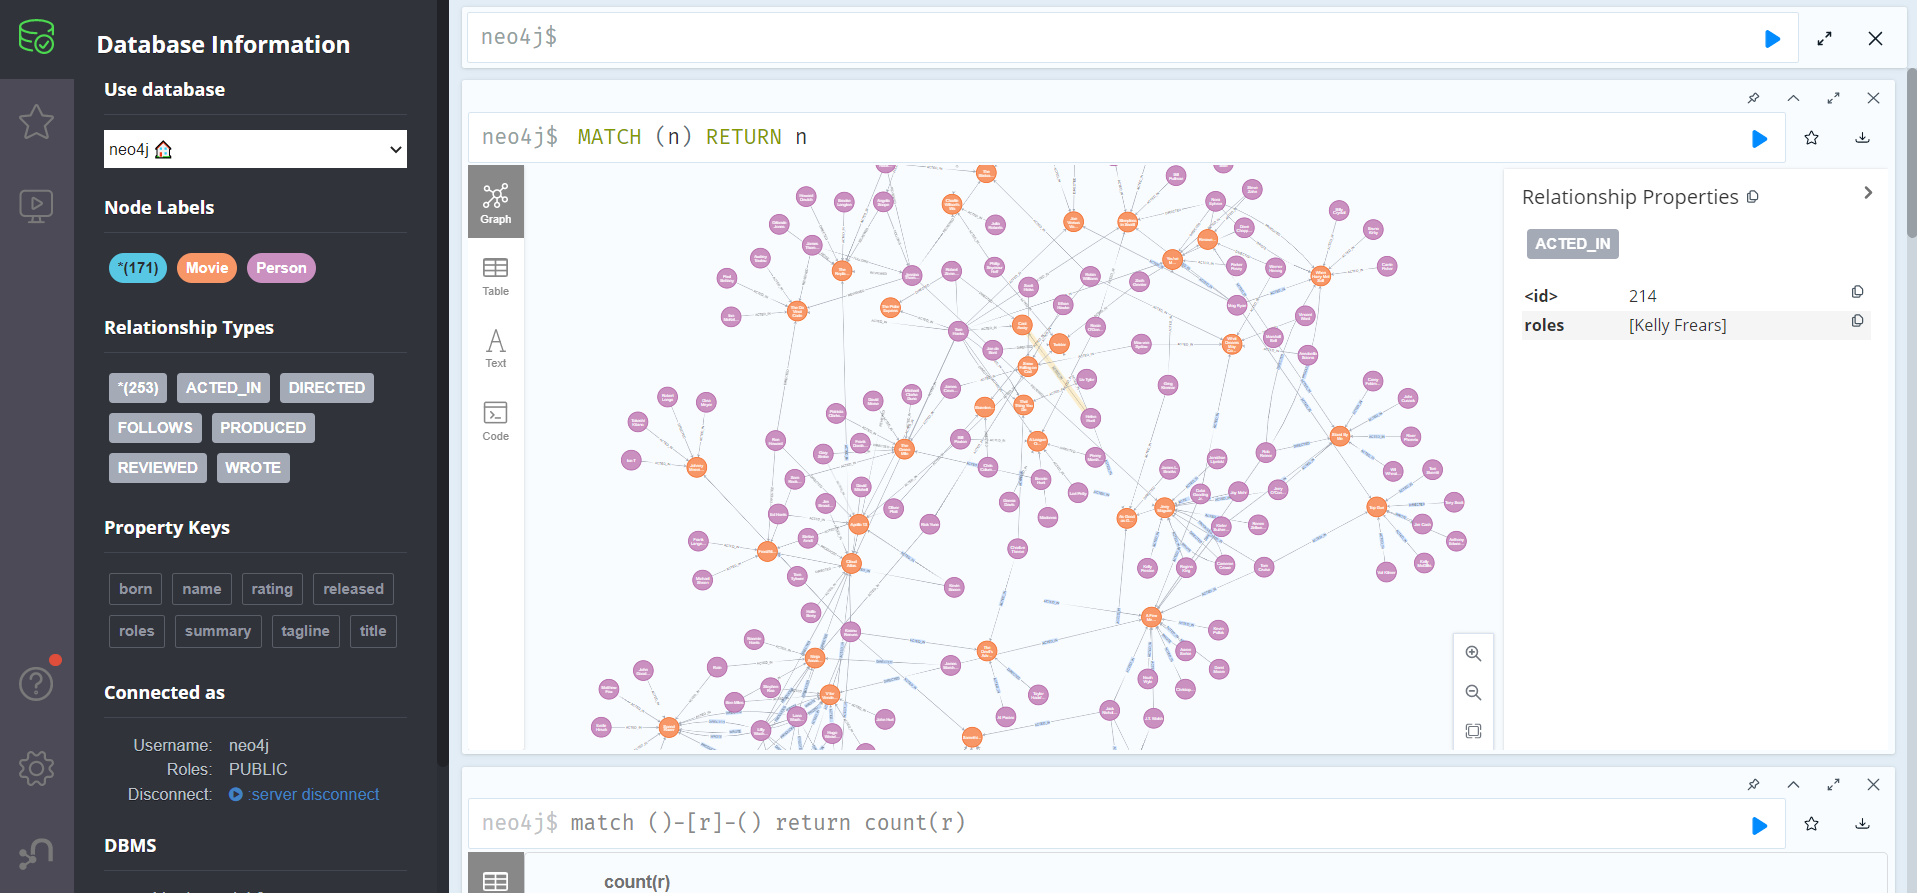

In [2]:
from IPython.display import Image
# Image(filename='1.png') # browser

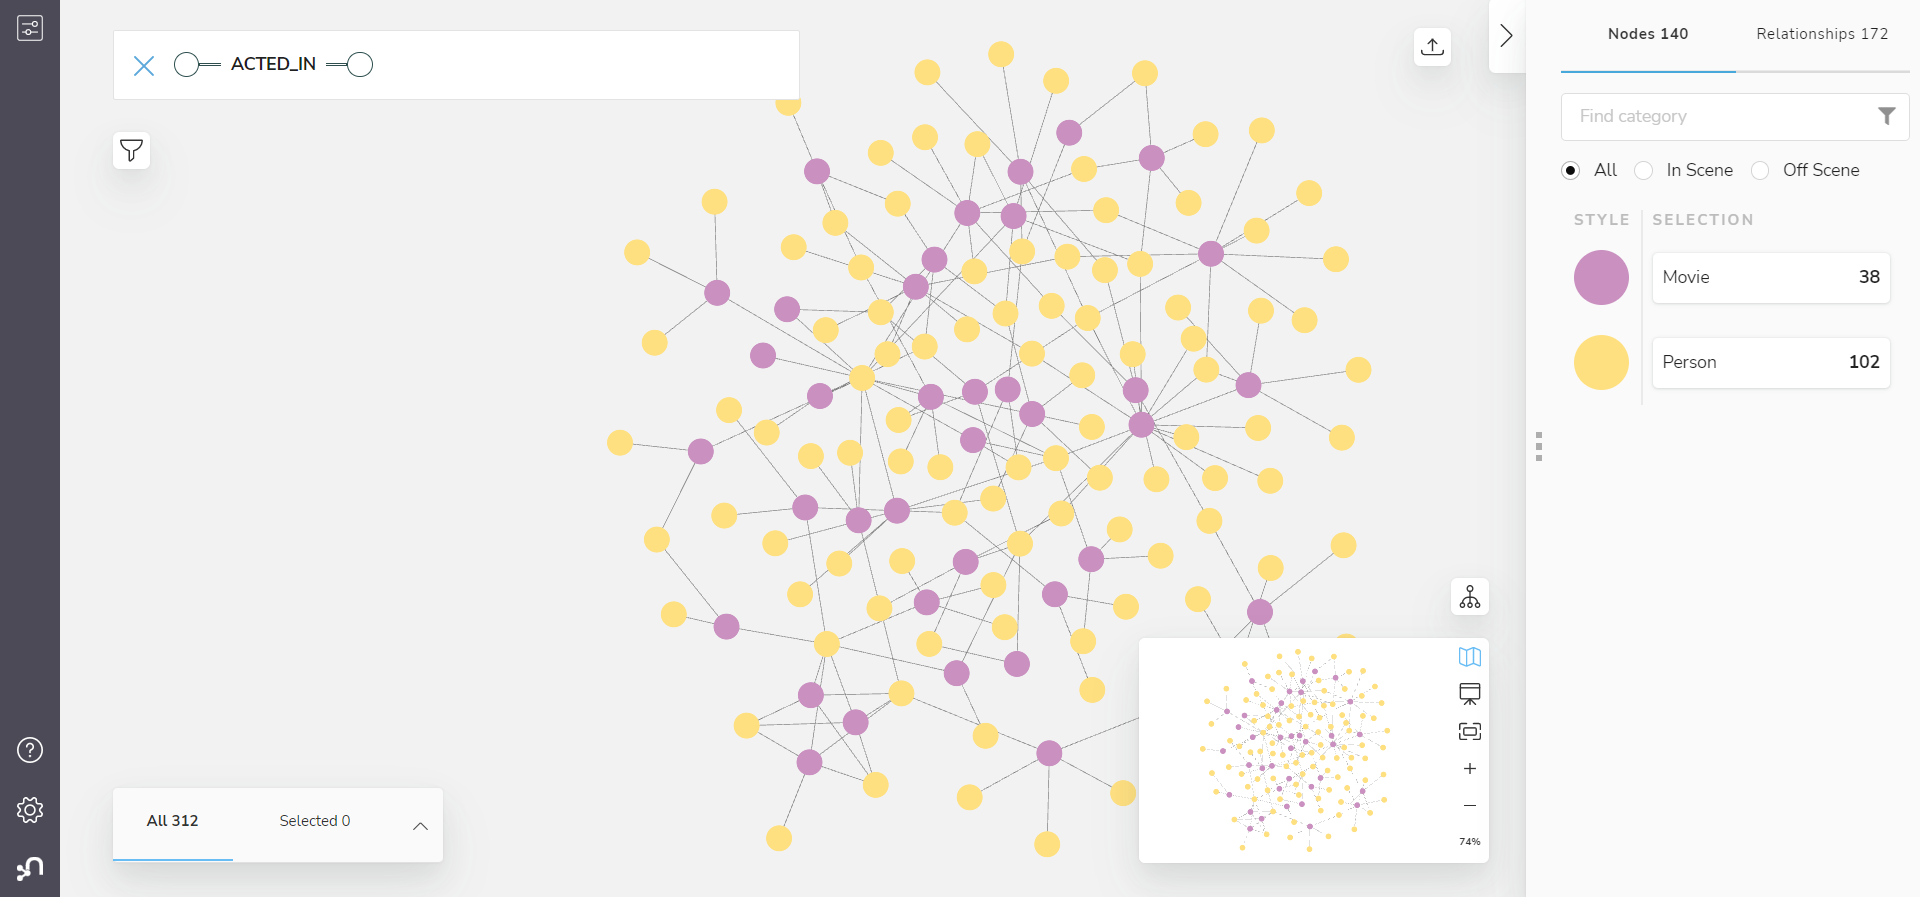

In [3]:
# Image(filename='2.png') # bloom

Next, install and import Neo4j library for python (alternatively, you can also use [py2neo](https://py2neo.org/2021.1/)):

In [4]:
!pip install neo4j

In [5]:
from neo4j import GraphDatabase
import logging

## 2. Cypher query using python

Running Cypher in python is pretty easy and straightforward, although in a production environment you may want to write them in a much more embedded, structred, and complicated way. Let's start by initiating the driver:

In [6]:
driver = GraphDatabase.driver(
    url, 
    auth=(user, password)
)


To know more about Cypher, read the [Documentation](https://neo4j.com/developer/cypher/).

In the database created there are two types of nodes - nodes with the label of "Person" and nodes with the label of "Movie". In the following example we want to find the node which represents Keanu Reeves (the node has a "name" property with a value of "Keanu Reeves"):

In [7]:
query = (
    "MATCH (n:Person) "
    "WHERE n.name = 'Keanu Reeves' "
    "RETURN n"
)

You could also write in the following way. The two queries are identical. 

In [8]:
query = (
    "MATCH (n:Person {name: 'Keanu Reeves'}) "
    "RETURN n"
)

Embedd the query in a transaction, and print the result as a list with only one element since there is only one node returned:

In [9]:
with driver.session() as session:
    response = list(session.run(query))
print(response)

[<Record n=<Node id=1 labels=frozenset({'Person'}) properties={'born': 1964, 'name': 'Keanu Reeves'}>>]


Here is another example which creates two person nodes and add a relationship (edge) with label "KNOWS" in between. 

In [10]:
query = (
    "CREATE (p1:Person {name: 'Alice'}) "
    "CREATE (p2:Person {name: 'Bob'}) "
    "CREATE (p1)-[:KNOWS]->(p2) "
    "RETURN p1, p2"
)

Finally, here is slightly more complex query. It finds all the people acted in any movie whose name start with "Tom", count the number of movies each of them has acted, and return the result ordered by these people's name.

In [11]:
query = (
    "MATCH (p:Person)-[:ACTED_IN]->(m:Movie) "
    "WHERE p.name STARTS WITH 'Tom' "
    "RETURN "
        "p.name AS name, "
        "count(m) AS count "
    "ORDER BY name"
)

In [12]:
import pandas as pd

with driver.session() as session:
    response = list(session.run(query))
pd.DataFrame(response, columns = ['Actor', 'Number of movies acted'])

,Actor,Number of movies acted
0,Tom Cruise,3
1,Tom Hanks,12
2,Tom Skerritt,1


In [13]:
driver.close()

## 3. Graph analysis

There are many common graph analysis problems:

1. Centrality & Importance
2. Community Detection
3. Similarity
4. Node Embedding
5. Supervised Machine Learning,
6. Pathfinding & Search

etc.

These tasks can be done using Neo4j Graph Data Science service, however it's not free if using AuraDS as the cloud solution. <b>Therefore, we need to download the Neo4j Desktop Client [here](https://neo4j.com/download-center/)</b>. Once download, the client can open Browser and Bloom instances on localhost. After the database is created, import your own data or choose one of the sample datasets. I am using the following one for demostration:

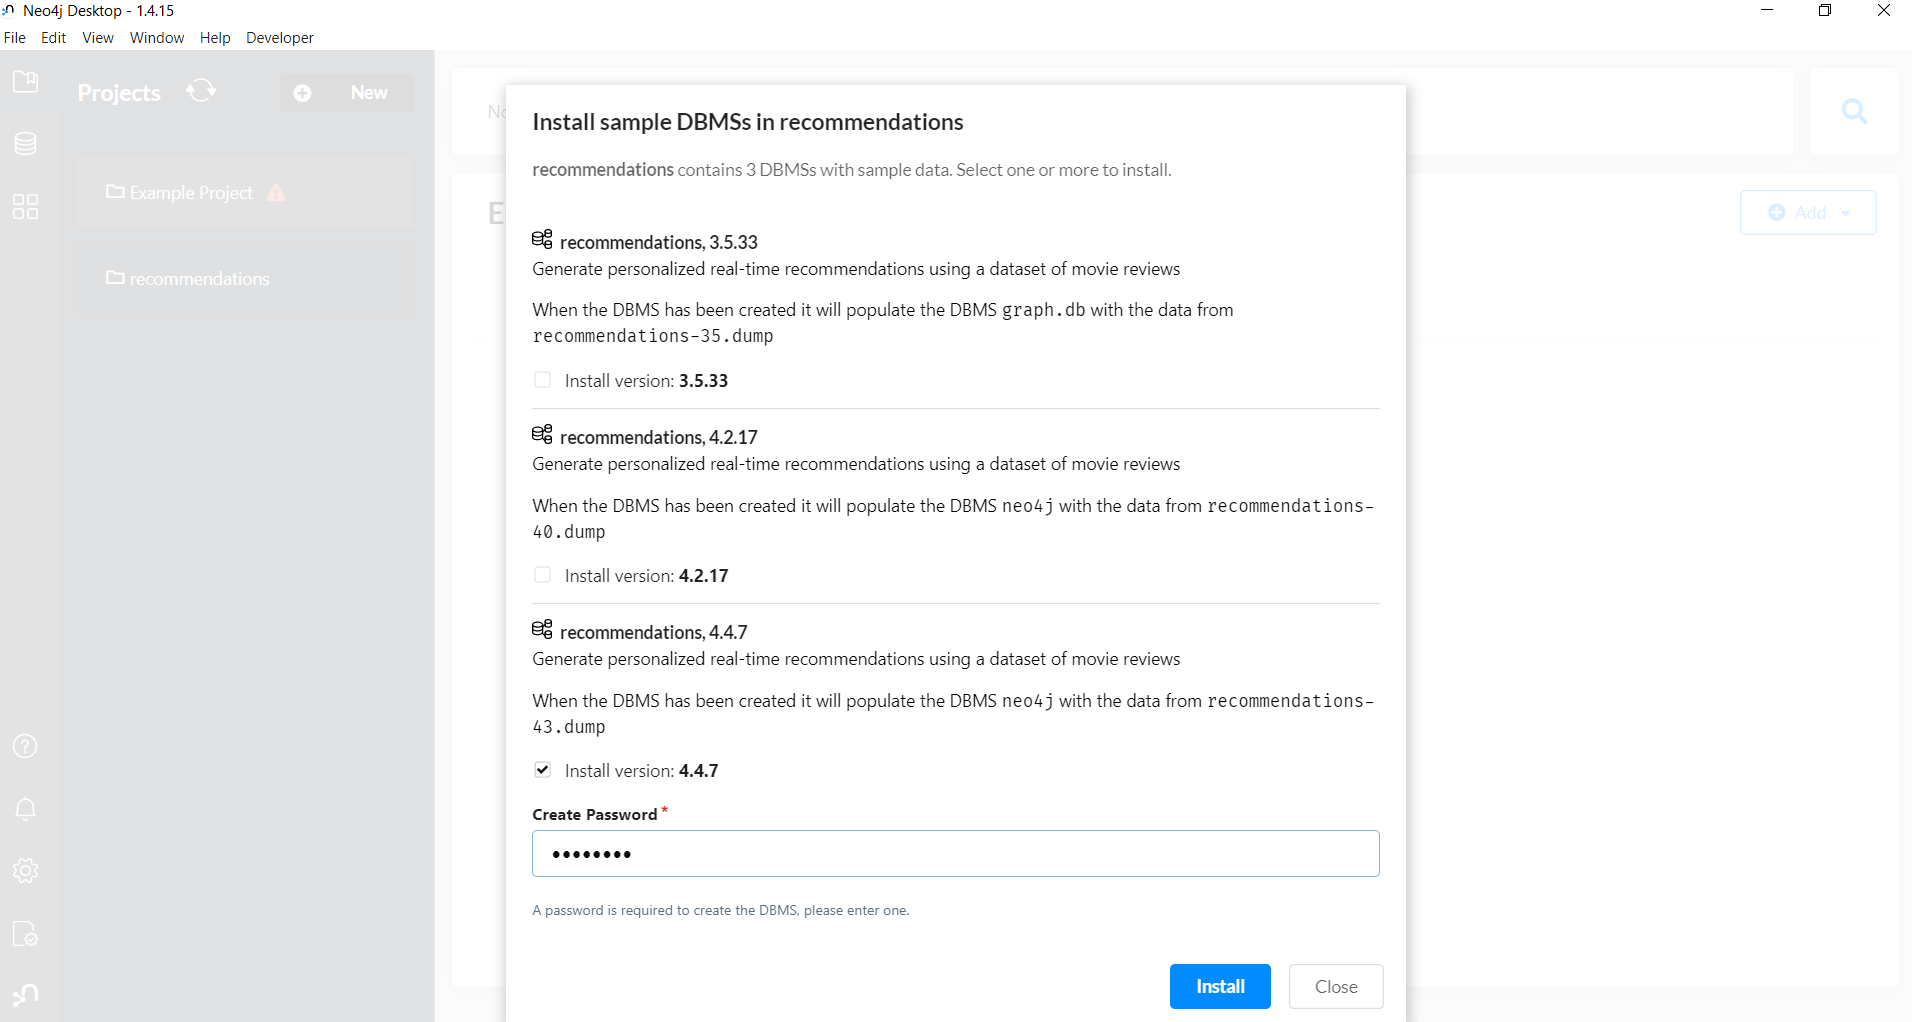

In [14]:
# Image(filename='3.png')

Once the database is created, make sure to double check if the Graph Data Science Library under database Plugin tab is > 2.0. Otherwise some of the scripts below will not work.

In [15]:
!pip install graphdatascience

In [16]:
from graphdatascience import GraphDataScience

# change to your user name and password
url = "bolt://localhost:7687"
user = "neo4j"
password = "password" 

gds = GraphDataScience(url, auth=(user, password))
print(gds.version()) # make sure version > 2.0

2.1.0


Before any analysis actions, the first step is to construct a graph object since Neo4j Graph Data Science Library is designed to operate based on it. The first argument provides the name of the graph object instance; the second and third arguments specify which ndoes and edges to map based on labels.

In [17]:
try:
    G, _ = gds.graph.project("graph",
                             node_spec=["Person", "Movie"],
                             relationship_spec=["ACTED_IN", "DIRECTED"])
except:
    G = gds.graph.get("graph")
    G.drop()
    G, _ = gds.graph.project("graph",
                             node_spec=["Person", "Movie"],
                             relationship_spec=["ACTED_IN", "DIRECTED"])

In [18]:
G.node_count()

28172

First, let's do a simple node degree analysis, which shows how many edges are associated with each of the node in the database. Note that in the examples below I try not to do any further parameter specification/tuning, just to make the demostraion simple. I will provide the link to the documentation where detailed explainations of parameters for each algorithm are provided.

In [19]:
res = gds.degree.stats(G)
res

centralityDistribution    {'p99': 17.00011444091797, 'min': 0.0, 'max': ...
postProcessingMillis                                                     54
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'jobId': '826e49c0-6c65-4ade-a951-a2b7c30810c...
Name: 0, dtype: object

In [20]:
res = gds.degree.stream(G)
res.sort_values(by='score')

,nodeId,score
0,0,0.0
6092,6111,0.0
6091,6110,0.0
6090,6109,0.0
6089,6108,0.0
...,...,...
15562,17343,45.0
14203,15706,49.0
12005,13100,58.0
11657,12708,65.0


The result above shows the score, or node degree (number of edges connecting to a node) of each node by its id. The figure below shows the node with the highest score (largest node degree), as well as nodes and edges that are connecting to it.

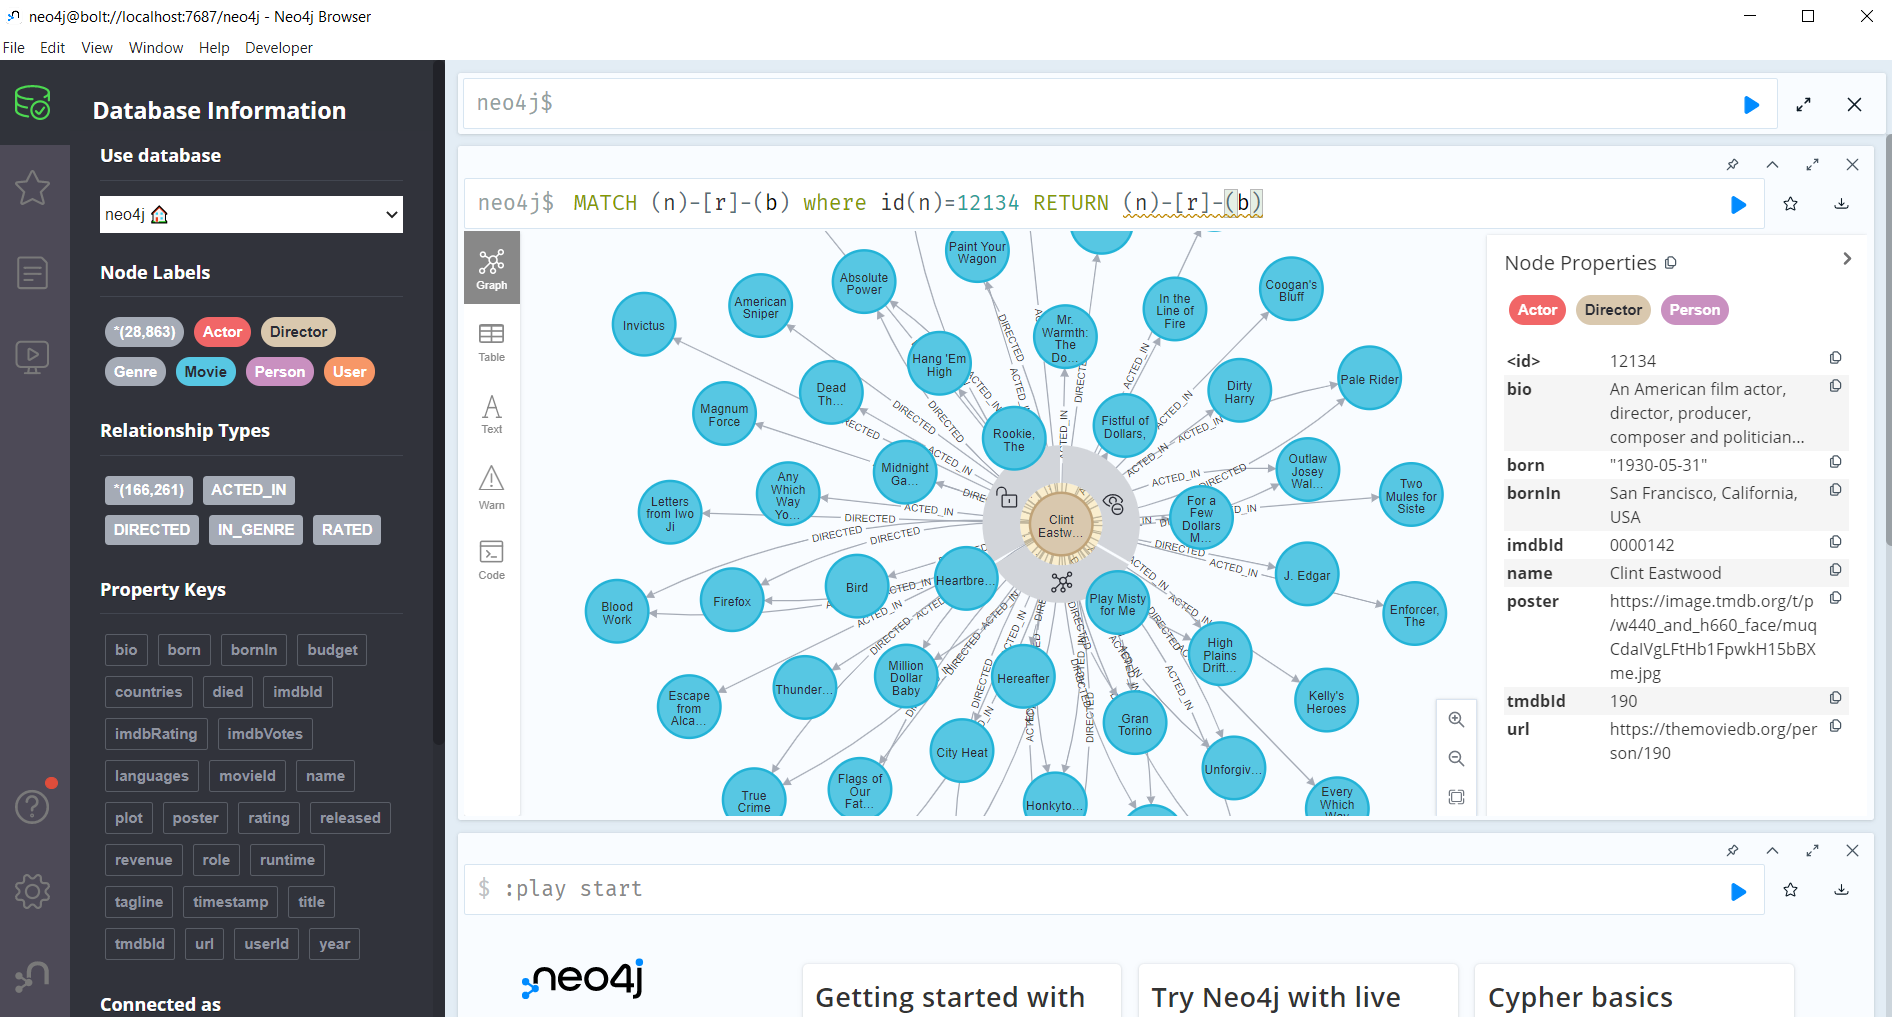

In [21]:
# Image(filename='4.png')

Next we try another algorithm. ArticleRank is a variant of the Page Rank algorithm, which measures the transitive influence of nodes.m Page Rank follows the assumption that relationships originating from low-degree nodes have a higher influence than relationships from high-degree nodes. Article Rank lowers the influence of low-degree nodes by lowering the scores being sent to their neighbors in each iteration.

In [22]:
res = gds.articleRank.stream(G)
res.sort_values(by='score')

,nodeId,score
14085,15561,0.150000
18787,21439,0.150000
18786,21437,0.150000
18785,21436,0.150000
18784,21435,0.150000
...,...,...
8142,8162,0.655099
1036,1055,0.723165
7956,7976,0.795031
6629,6648,0.891616


Similarly, the figure below shows the node with the highest score. Note that due to the change of the algorithm, this is not the same node as the one in the previous example with the largest node degree. Naturally, different graph algorithms are suitable for different problems.

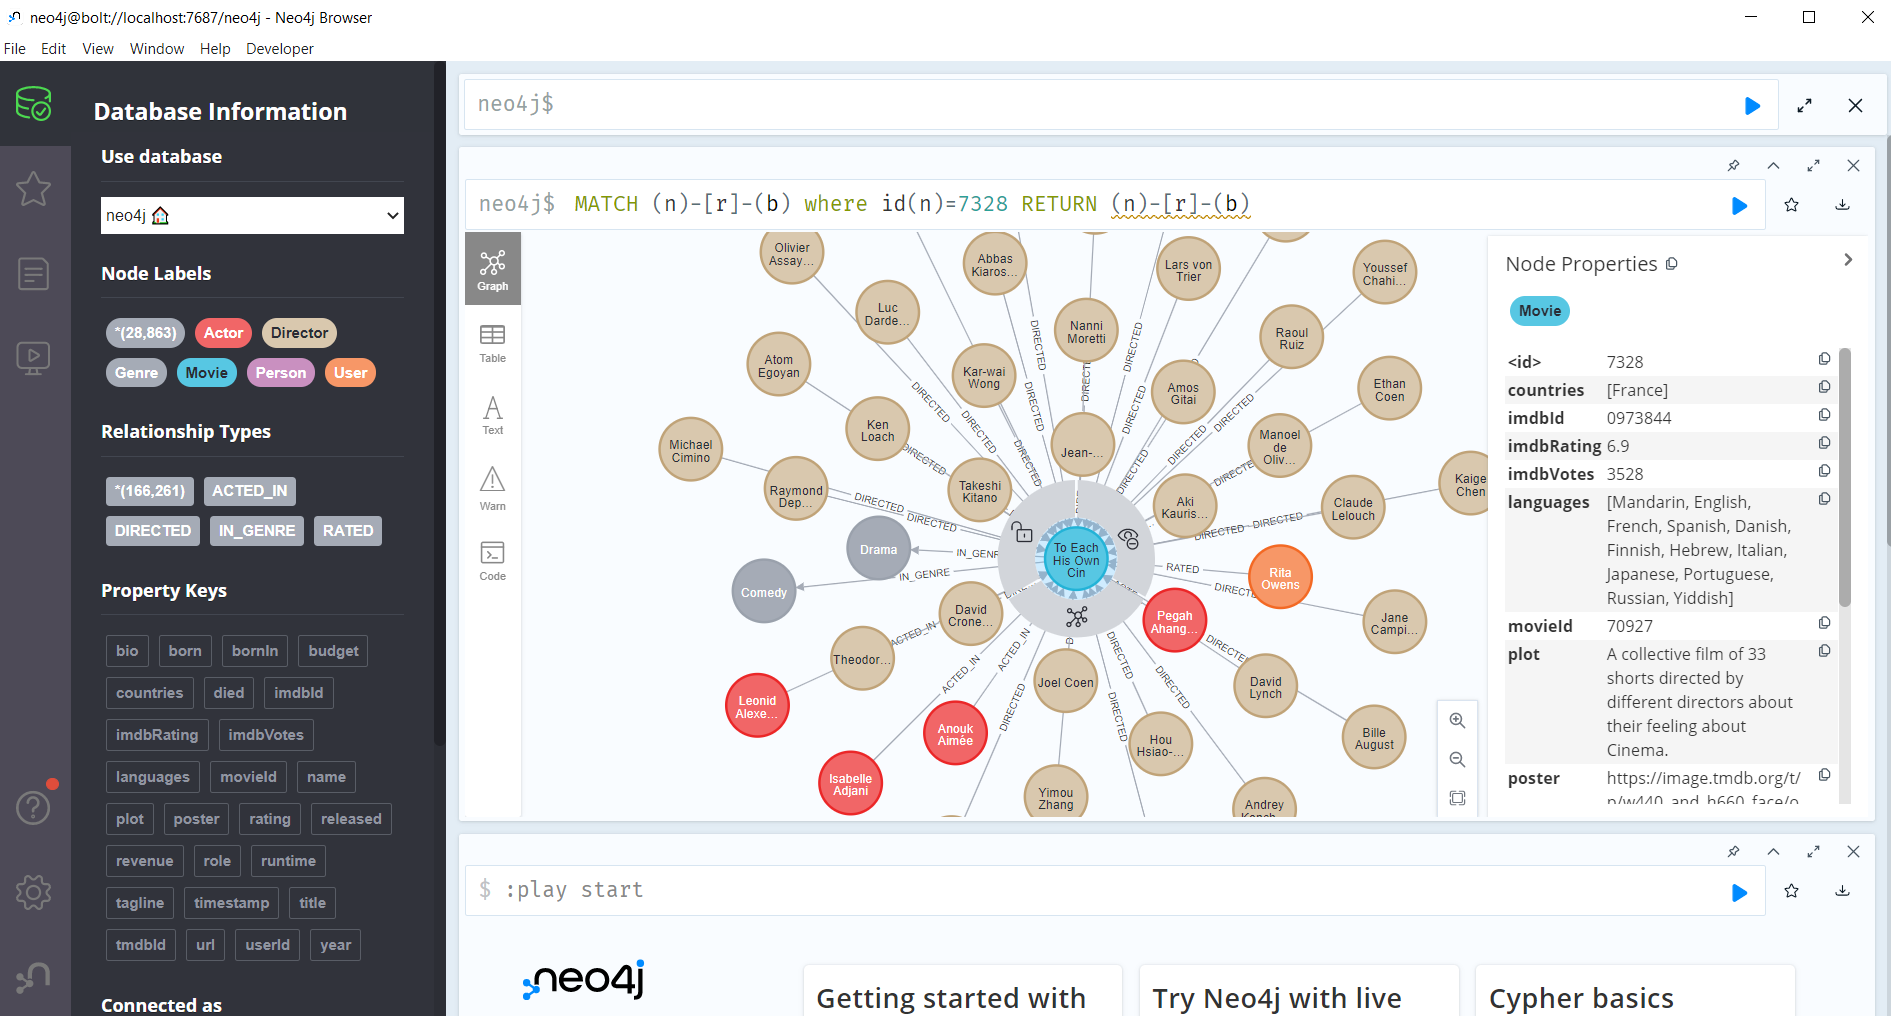

In [23]:
# Image(filename='5.png')

Finally, we use the Louvain method as an algorithm to detect communities in large networks. The result separates all nodes in the database into different communities by ids.

In [24]:
res = gds.louvain.stream(G)
res.sort_values(by='communityId')

,nodeId,communityId,intermediateCommunityIds
0,0,0,None
25281,30134,0,None
1452,1471,0,None
17539,19826,0,None
11119,12086,0,None
...,...,...,...
9122,9142,9122,None
9526,10243,9123,None
9524,10241,9123,None
9123,9143,9123,None


There are more graph algorithm introduced in the Neo4j Graph Data Science [Documentation](https://neo4j.com/docs/graph-data-science/current/algorithms/). Note that the page does not directly provide any Python code that you can copy&paste and play with. Instead these examples are shown using Cypher.

You can also query the database and write your own algorithm scripts as well, rather than using the built-in functions provided by the Graph Data Science service.

## 4. Graph visualization

Go to either [Neo4j Browser](https://browser.neo4j.io/) or [Neo4j Bloom](https://bloom.neo4j.io/) to visualize graph databases and query results if you are using Neo4j Aura, or click the Open button on your Neo4j Desktop to open these visualizers locally. Additionally, check the tools available [here](https://neo4j.com/developer/tools-graph-visualization/) if you want fancy graphs. Although technically it is possible to visualize graph databases and query results in jupyter notebook, I think there is little meaning to do so.